# Tier 3: PLM (ESM-2) Embeddings + BiLSTM Training

This notebook implements training for the **Tier 3** architecture:
- **Pre-computed ESM-2 embeddings** as input (1280-dim)
- Optional 1D CNN for local refinement
- BiLSTM for sequential modeling

## Prerequisites
Run the embedding extraction script first to generate ESM-2 embeddings:
```bash
python scripts/extract_embeddings.py
```

## Expected Performance
- Q3 Accuracy: ~88-91%
- Q8 Accuracy: ~77-82%

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '../..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import os
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
from src.config import Tier3Config, LEAKAGE_TRAIN_IDS
from src.data import PLMEmbeddingDataset, collate_fn
from src.models.tier3_plm_bilstm import PLMBiLSTM
from src.losses import get_multitask_loss
from src.augmentation import EmbeddingAugmenter
from src.metrics import evaluate_model, plot_confusion_matrix
from src.training import Trainer, create_optimizer, create_scheduler, plot_training_history

## 2. Configuration

In [3]:
config = Tier3Config(
    # Data
    max_seq_length=512,
    batch_size=32,
    
    # Model
    embedding_dim=480,
    embeddings_path='../../data/embeddings',
    
    use_cnn=True,
    cnn_filters=128,
    cnn_kernels=[3, 5],
    
    lstm_hidden=256,
    lstm_layers=2,
    lstm_dropout=0.2,
    
    fc_hidden=256,
    fc_dropout=0.2,
    
    # Training
    learning_rate=1e-4,
    weight_decay=0.01,
    max_epochs=50,
    patience=10,
    gradient_clip=1.0,
    
    # Loss
    focal_gamma=2.0,
    q8_loss_weight=1.0,
    q3_loss_weight=0.5,
    
    # Augmentation
    augmentation_level=2,  # Light noise injection for embeddings
    
    # Checkpointing
    checkpoint_dir='../../checkpoints/tier3_plm_bilstm',
)

print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Embedding dim: {config.embedding_dim}")
print(f"  Use CNN: {config.use_cnn}")

Configuration:
  Model: tier3_plm_bilstm
  Embedding dim: 480
  Use CNN: True


## 3. Check Embeddings Availability

In [4]:
embeddings_dir = Path(config.embeddings_path)

if not embeddings_dir.exists():
    print("⚠️  Embeddings directory not found!")
    print(f"   Expected at: {embeddings_dir.absolute()}")
    print("\nTo extract embeddings, run:")
    print("   python scripts/extract_embeddings.py")
    print("\nAlternatively, using on-the-fly embedding extraction (slower)...")
    USE_PRECOMPUTED = False
else:
    embedding_files = list(embeddings_dir.glob("*.pt"))
    print(f"✅ Found {len(embedding_files)} pre-computed embeddings")
    USE_PRECOMPUTED = True

✅ Found 7262 pre-computed embeddings


## 4. Data Loading

In [5]:
if USE_PRECOMPUTED:
    # Use PLM embedding dataset
    import pandas as pd
    
    # Load full data for splitting
    train_df = pd.read_csv('../../data/train.csv')
    train_df = train_df[~train_df['id'].isin(LEAKAGE_TRAIN_IDS)].reset_index(drop=True)
    
    # Split
    np.random.seed(SEED)
    val_size = int(len(train_df) * 0.1)
    val_indices = np.random.choice(len(train_df), val_size, replace=False)
    train_indices = [i for i in range(len(train_df)) if i not in val_indices]
    
    train_split = train_df.iloc[train_indices].reset_index(drop=True)
    val_split = train_df.iloc[val_indices].reset_index(drop=True)
    
    train_split.to_csv('/tmp/plm_train.csv', index=False)
    val_split.to_csv('/tmp/plm_val.csv', index=False)
    
    # Create datasets
    train_dataset = PLMEmbeddingDataset(
        '/tmp/plm_train.csv',
        config.embeddings_path,
        max_length=config.max_seq_length,
    )
    
    val_dataset = PLMEmbeddingDataset(
        '/tmp/plm_val.csv',
        config.embeddings_path,
        max_length=config.max_seq_length,
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
    )
    
else:
    # On-the-fly embedding extraction using OnTheFlyPLMDataset
    print("Using on-the-fly embedding extraction...")
    print("⚠️  This is slower. Pre-compute embeddings for faster training.")
    
    from transformers import EsmTokenizer, EsmModel
    from src.data import OnTheFlyPLMDataset
    import pandas as pd
    
    # Load ESM-2 model
    ESM_MODEL = "facebook/esm2_t33_650M_UR50D"
    print(f"Loading {ESM_MODEL}...")
    tokenizer = EsmTokenizer.from_pretrained(ESM_MODEL)
    esm_model = EsmModel.from_pretrained(ESM_MODEL)
    esm_model = esm_model.to(DEVICE)
    esm_model.eval()
    print(f"✅ ESM-2 loaded")
    
    # Load and split data
    train_df = pd.read_csv('../../data/train.csv')
    train_df = train_df[~train_df['id'].isin(LEAKAGE_TRAIN_IDS)].reset_index(drop=True)
    
    np.random.seed(SEED)
    val_size = int(len(train_df) * 0.1)
    val_indices = np.random.choice(len(train_df), val_size, replace=False)
    train_indices = [i for i in range(len(train_df)) if i not in val_indices]
    
    train_split = train_df.iloc[train_indices].reset_index(drop=True)
    val_split = train_df.iloc[val_indices].reset_index(drop=True)
    
    train_split.to_csv('/tmp/plm_train.csv', index=False)
    val_split.to_csv('/tmp/plm_val.csv', index=False)
    
    # Create on-the-fly datasets
    train_dataset = OnTheFlyPLMDataset(
        '/tmp/plm_train.csv',
        esm_model=esm_model,
        tokenizer=tokenizer,
        device=DEVICE,
        max_length=config.max_seq_length,
    )
    
    val_dataset = OnTheFlyPLMDataset(
        '/tmp/plm_val.csv',
        esm_model=esm_model,
        tokenizer=tokenizer,
        device=DEVICE,
        max_length=config.max_seq_length,
    )
    
    # Use smaller batch size due to on-the-fly extraction
    train_loader = DataLoader(
        train_dataset,
        batch_size=max(1, config.batch_size // 4),  # Smaller batch
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,  # No multiprocessing with GPU model
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=max(1, config.batch_size // 4),
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
    )

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 205
Val batches: 23


## 5. Model Initialization

In [6]:
model = PLMBiLSTM(
    embedding_dim=config.embedding_dim,
    use_cnn=config.use_cnn,
    cnn_filters=config.cnn_filters,
    cnn_kernels=config.cnn_kernels,
    lstm_hidden=config.lstm_hidden,
    lstm_layers=config.lstm_layers,
    lstm_dropout=config.lstm_dropout,
    fc_hidden=config.fc_hidden,
    fc_dropout=config.fc_dropout,
)

print(f"Model parameters: {model.count_parameters():,}")
model = model.to(DEVICE)

Model parameters: 3,512,075


In [7]:
# Test forward pass
sample_batch = next(iter(train_loader))
test_input = sample_batch['features'].to(DEVICE)
q8_out, q3_out = model(test_input)
print(f"Q8 output shape: {q8_out.shape}")
print(f"Q3 output shape: {q3_out.shape}")

Q8 output shape: torch.Size([32, 463, 8])
Q3 output shape: torch.Size([32, 463, 3])


## 6. Loss Function & Training

In [8]:
loss_fn = get_multitask_loss(
    loss_type='focal',
    q8_weight=config.q8_loss_weight,
    q3_weight=config.q3_loss_weight,
    gamma=config.focal_gamma,
)

optimizer = create_optimizer(
    model,
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
)

scheduler = create_scheduler(
    optimizer,
    scheduler_type='cosine',
    num_epochs=config.max_epochs,
)

In [9]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    checkpoint_dir=config.checkpoint_dir,
    gradient_clip=config.gradient_clip,
    use_amp=torch.cuda.is_available(),
    use_tracking=True,
    trackio_space_id='thethinkmachine/trackio',  # HuggingFace Space for logs
    experiment_name='tier3_plm_bilstm',
    hub_model_id='thethinkmachine/ProteinSST-PLMBiLSTM',
    training_config=config,
)

In [10]:
history = trainer.train(
    num_epochs=config.max_epochs,
    patience=config.patience,
    save_every=5,
)

📊 Logging to HuggingFace Space: thethinkmachine/trackio
* Trackio project initialized: tier3_plm_bilstm
* Trackio metrics will be synced to Hugging Face Dataset: thethinkmachine/trackio-dataset
* Found existing space: https://huggingface.co/spaces/thethinkmachine/trackio
* View dashboard by going to: https://thethinkmachine-trackio.hf.space/


* Created new run: thethinkmachine-1765723215
✓ Experiment tracking enabled (Trackio)
Starting training for 50 epochs...
Device: cuda
Model parameters: 3,512,075


Epoch 1: 100%|██████████| 205/205 [00:13<00:00, 15.49it/s, loss=1.25, q8_loss=1.11, q3_loss=0.271]  


Epoch 1/50 (14.6s) | Train Loss: 1.0166 | Val Loss: 0.8876 | Q8 Acc: 0.4738 | Q3 Acc: 0.6607 | Q8 F1: 0.3018 | Q3 F1: 0.6561 | H-F1: 0.4135 | LR: 0.000099 *


Epoch 2: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s, loss=0.901, q8_loss=0.783, q3_loss=0.235]


Epoch 2/50 (14.2s) | Train Loss: 0.9005 | Val Loss: 0.8607 | Q8 Acc: 0.4515 | Q3 Acc: 0.6833 | Q8 F1: 0.3000 | Q3 F1: 0.6771 | H-F1: 0.4158 | LR: 0.000096 *


Epoch 3: 100%|██████████| 205/205 [00:12<00:00, 15.95it/s, loss=0.73, q8_loss=0.617, q3_loss=0.225] 


Epoch 3/50 (14.1s) | Train Loss: 0.8714 | Val Loss: 0.8457 | Q8 Acc: 0.4665 | Q3 Acc: 0.6893 | Q8 F1: 0.3115 | Q3 F1: 0.6837 | H-F1: 0.4280 | LR: 0.000092 *


Epoch 4: 100%|██████████| 205/205 [00:12<00:00, 15.92it/s, loss=0.702, q8_loss=0.6, q3_loss=0.204]  


Epoch 4/50 (14.1s) | Train Loss: 0.8517 | Val Loss: 0.8398 | Q8 Acc: 0.4680 | Q3 Acc: 0.6845 | Q8 F1: 0.3127 | Q3 F1: 0.6802 | H-F1: 0.4284 | LR: 0.000086 *


Epoch 5: 100%|██████████| 205/205 [00:12<00:00, 15.94it/s, loss=0.736, q8_loss=0.635, q3_loss=0.2]  


Epoch 5/50 (14.1s) | Train Loss: 0.8333 | Val Loss: 0.8310 | Q8 Acc: 0.4778 | Q3 Acc: 0.6950 | Q8 F1: 0.3170 | Q3 F1: 0.6882 | H-F1: 0.4340 | LR: 0.000078 *


Epoch 6: 100%|██████████| 205/205 [00:12<00:00, 15.83it/s, loss=0.909, q8_loss=0.785, q3_loss=0.249]


Epoch 6/50 (14.1s) | Train Loss: 0.8185 | Val Loss: 0.8268 | Q8 Acc: 0.4582 | Q3 Acc: 0.6901 | Q8 F1: 0.3072 | Q3 F1: 0.6852 | H-F1: 0.4242 | LR: 0.000069


Epoch 7: 100%|██████████| 205/205 [00:12<00:00, 15.91it/s, loss=0.705, q8_loss=0.602, q3_loss=0.205]


Epoch 7/50 (14.1s) | Train Loss: 0.8040 | Val Loss: 0.8217 | Q8 Acc: 0.4994 | Q3 Acc: 0.6911 | Q8 F1: 0.3248 | Q3 F1: 0.6854 | H-F1: 0.4407 | LR: 0.000060 *


Epoch 8: 100%|██████████| 205/205 [00:12<00:00, 15.99it/s, loss=0.724, q8_loss=0.608, q3_loss=0.231]


Epoch 8/50 (14.1s) | Train Loss: 0.7920 | Val Loss: 0.8222 | Q8 Acc: 0.5025 | Q3 Acc: 0.6961 | Q8 F1: 0.3273 | Q3 F1: 0.6901 | H-F1: 0.4440 | LR: 0.000051 *


Epoch 9: 100%|██████████| 205/205 [00:12<00:00, 16.03it/s, loss=0.699, q8_loss=0.594, q3_loss=0.211]


Epoch 9/50 (13.9s) | Train Loss: 0.7791 | Val Loss: 0.8210 | Q8 Acc: 0.4855 | Q3 Acc: 0.6933 | Q8 F1: 0.3189 | Q3 F1: 0.6870 | H-F1: 0.4356 | LR: 0.000041


Epoch 10: 100%|██████████| 205/205 [00:12<00:00, 15.94it/s, loss=0.797, q8_loss=0.695, q3_loss=0.205]


Epoch 10/50 (14.0s) | Train Loss: 0.7693 | Val Loss: 0.8264 | Q8 Acc: 0.4946 | Q3 Acc: 0.6929 | Q8 F1: 0.3227 | Q3 F1: 0.6855 | H-F1: 0.4388 | LR: 0.000032


Epoch 11: 100%|██████████| 205/205 [00:12<00:00, 15.92it/s, loss=0.879, q8_loss=0.755, q3_loss=0.248]


Epoch 11/50 (14.0s) | Train Loss: 0.7591 | Val Loss: 0.8317 | Q8 Acc: 0.4926 | Q3 Acc: 0.6942 | Q8 F1: 0.3244 | Q3 F1: 0.6867 | H-F1: 0.4406 | LR: 0.000023


Epoch 12: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s, loss=0.767, q8_loss=0.668, q3_loss=0.196]


Epoch 12/50 (14.1s) | Train Loss: 0.7511 | Val Loss: 0.8229 | Q8 Acc: 0.4870 | Q3 Acc: 0.6965 | Q8 F1: 0.3223 | Q3 F1: 0.6903 | H-F1: 0.4395 | LR: 0.000015


Epoch 13: 100%|██████████| 205/205 [00:12<00:00, 15.87it/s, loss=0.682, q8_loss=0.589, q3_loss=0.187]


Epoch 13/50 (14.0s) | Train Loss: 0.7452 | Val Loss: 0.8262 | Q8 Acc: 0.4710 | Q3 Acc: 0.6973 | Q8 F1: 0.3172 | Q3 F1: 0.6915 | H-F1: 0.4349 | LR: 0.000009


Epoch 14: 100%|██████████| 205/205 [00:12<00:00, 15.95it/s, loss=0.74, q8_loss=0.639, q3_loss=0.201] 


Epoch 14/50 (14.0s) | Train Loss: 0.7399 | Val Loss: 0.8234 | Q8 Acc: 0.4796 | Q3 Acc: 0.6997 | Q8 F1: 0.3207 | Q3 F1: 0.6938 | H-F1: 0.4386 | LR: 0.000005


Epoch 15: 100%|██████████| 205/205 [00:12<00:00, 15.80it/s, loss=0.708, q8_loss=0.611, q3_loss=0.194]


Epoch 15/50 (14.1s) | Train Loss: 0.7363 | Val Loss: 0.8258 | Q8 Acc: 0.4841 | Q3 Acc: 0.6960 | Q8 F1: 0.3215 | Q3 F1: 0.6904 | H-F1: 0.4387 | LR: 0.000002


Epoch 16: 100%|██████████| 205/205 [00:12<00:00, 15.81it/s, loss=0.727, q8_loss=0.618, q3_loss=0.217]


Epoch 16/50 (14.1s) | Train Loss: 0.7336 | Val Loss: 0.8264 | Q8 Acc: 0.4879 | Q3 Acc: 0.6975 | Q8 F1: 0.3228 | Q3 F1: 0.6914 | H-F1: 0.4401 | LR: 0.000100


Epoch 17: 100%|██████████| 205/205 [00:12<00:00, 15.93it/s, loss=0.726, q8_loss=0.63, q3_loss=0.191] 


Epoch 17/50 (14.0s) | Train Loss: 0.7559 | Val Loss: 0.8451 | Q8 Acc: 0.4673 | Q3 Acc: 0.6932 | Q8 F1: 0.3108 | Q3 F1: 0.6881 | H-F1: 0.4282 | LR: 0.000100


Epoch 18: 100%|██████████| 205/205 [00:12<00:00, 15.90it/s, loss=0.821, q8_loss=0.713, q3_loss=0.215]


Epoch 18/50 (14.0s) | Train Loss: 0.7492 | Val Loss: 0.8284 | Q8 Acc: 0.4870 | Q3 Acc: 0.6983 | Q8 F1: 0.3205 | Q3 F1: 0.6914 | H-F1: 0.4380 | LR: 0.000099

Early stopping triggered at epoch 18
* Run finished. Uploading logs to Trackio (please wait...)
✓ Experiment tracking finished


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✓ Model pushed to: https://huggingface.co/thethinkmachine/ProteinSST-PLMBiLSTM

Training complete!
Best Harmonic F1: 0.4440
Best Q8 F1: 0.3273
Best Q8 Accuracy: 0.5025
Best Val Loss: 0.8222


## 7. Evaluation

/tmp/ipykernel_469158/68225983.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


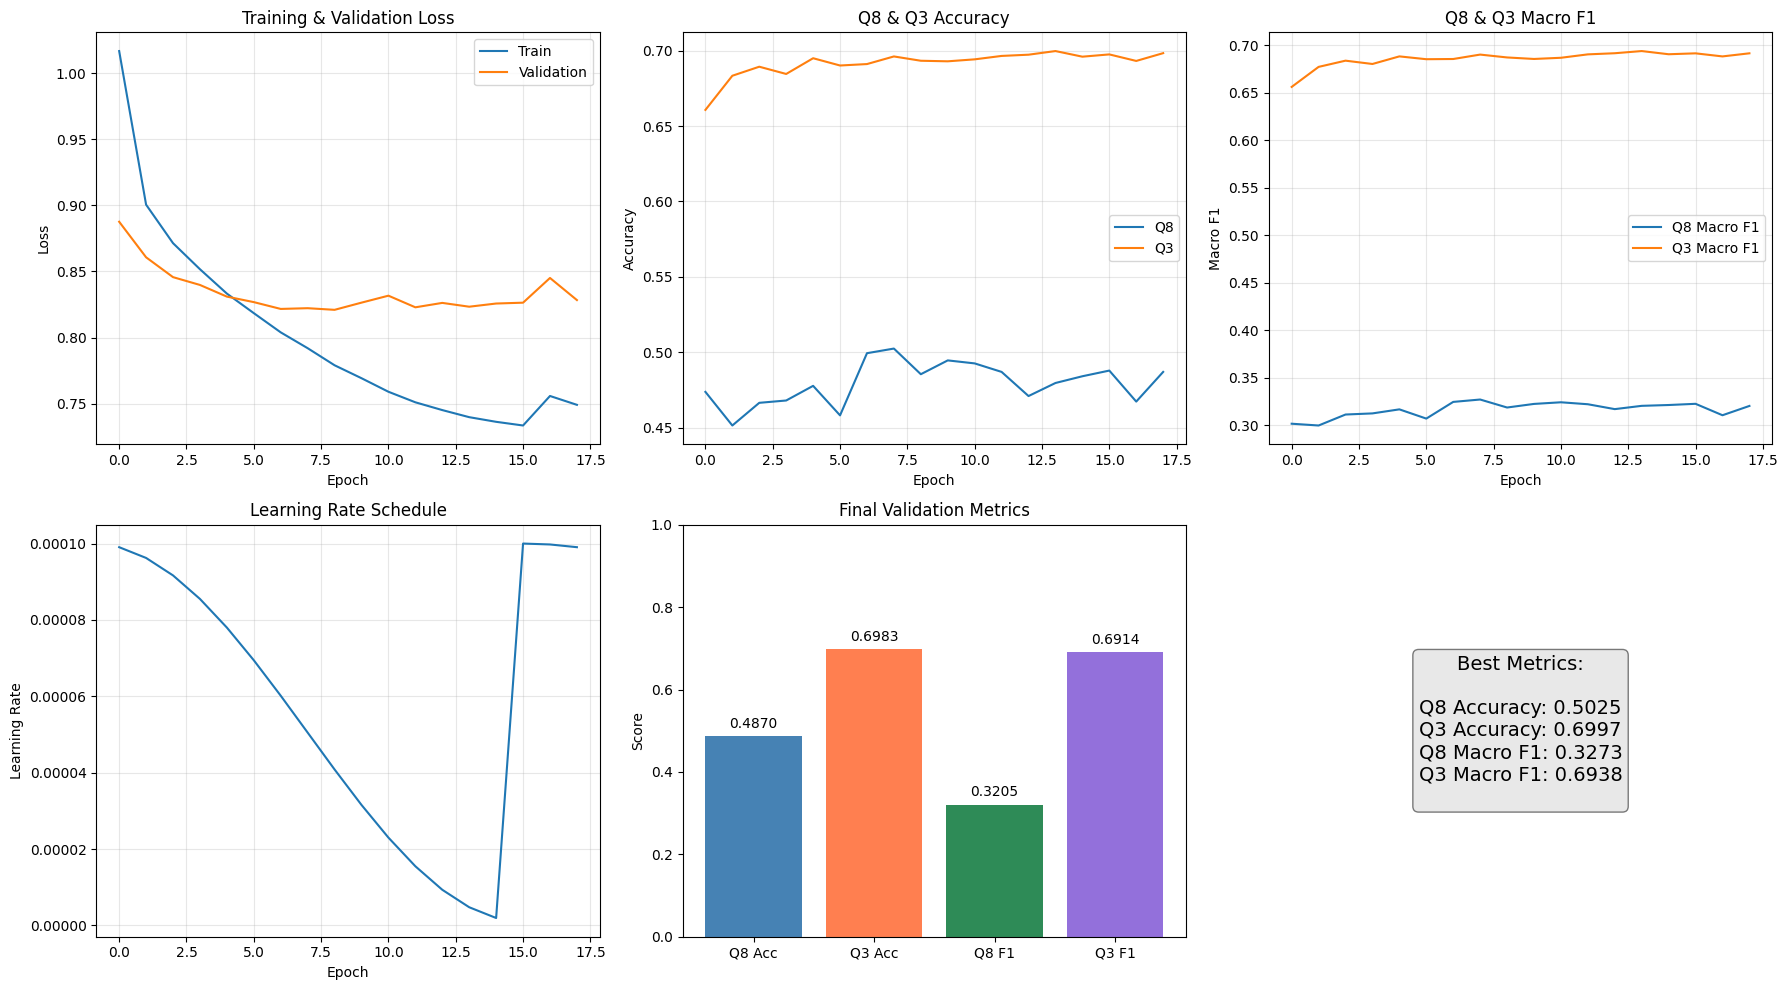

In [11]:
fig = plot_training_history(history, save_path=f'{config.checkpoint_dir}/training_history.png')
fig.show()

In [12]:
checkpoint = torch.load(f'{config.checkpoint_dir}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

report = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=DEVICE,
    compute_sov=True,
)

report.print_report()

EVALUATION REPORT

============================== Q8 (8-state) ==============================
Accuracy: 0.5025 (50.25%)
Macro F1: 0.3273
SOV Score: 55.33

Per-class metrics:
Class           Precision    Recall       F1           Support   
------------------------------------------------------------
G (3₁₀-helix)   0.1236       0.3935       0.1882       6209
H (α-helix)     0.7894       0.6778       0.7293       53946
I (π-helix)     0.0000       0.0000       0.0000       16
E (β-strand)    0.5967       0.6745       0.6332       35212
B (β-bridge)    0.0431       0.2864       0.0749       1840
T (Turn)        0.3254       0.5048       0.3957       17908
S (Bend)        0.2470       0.2064       0.2249       12922
C (Coil)        0.8241       0.2404       0.3722       40625

============================== Q3 (3-state) ==============================
Accuracy: 0.6961 (69.61%)
Macro F1: 0.6901
SOV Score: 74.14

Per-class metrics:
Class           Precision    Recall       F1           Suppo

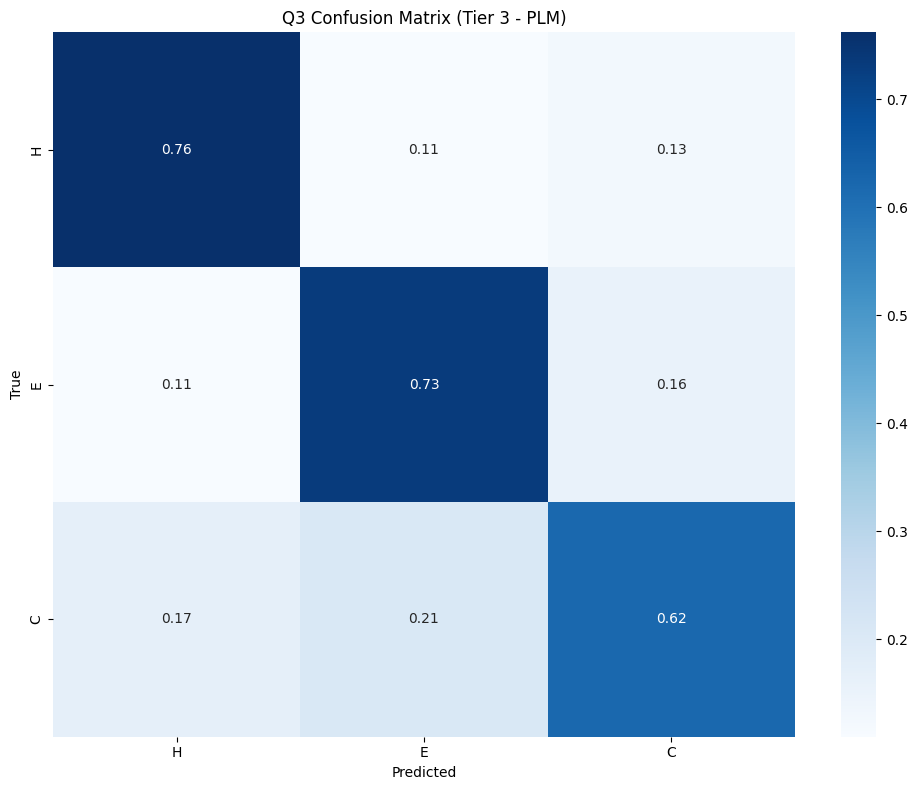

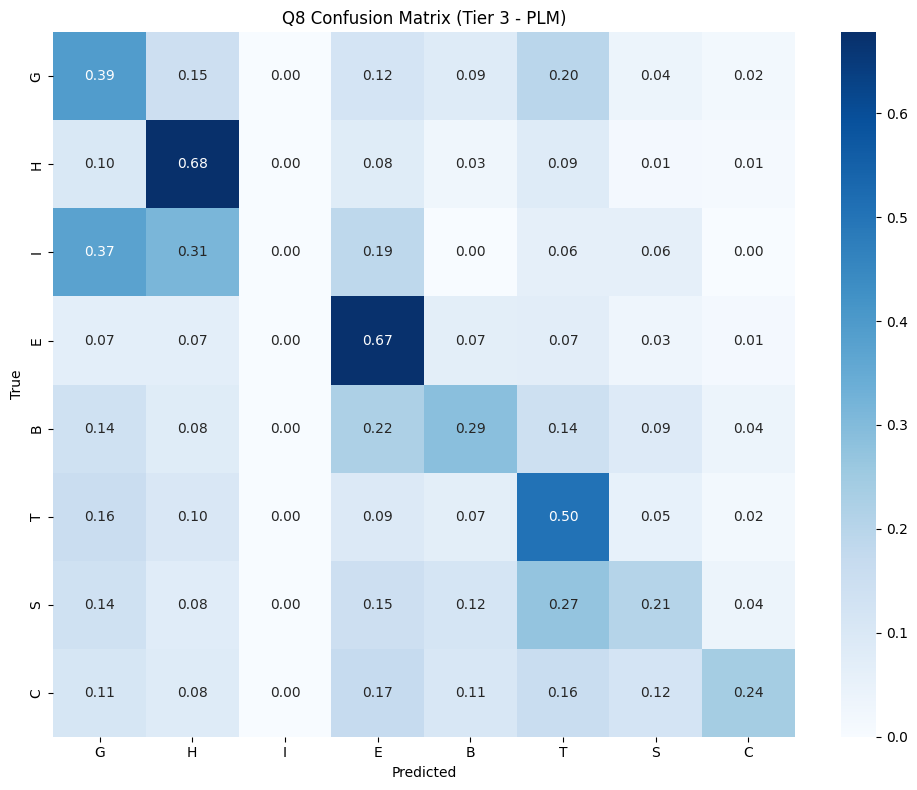

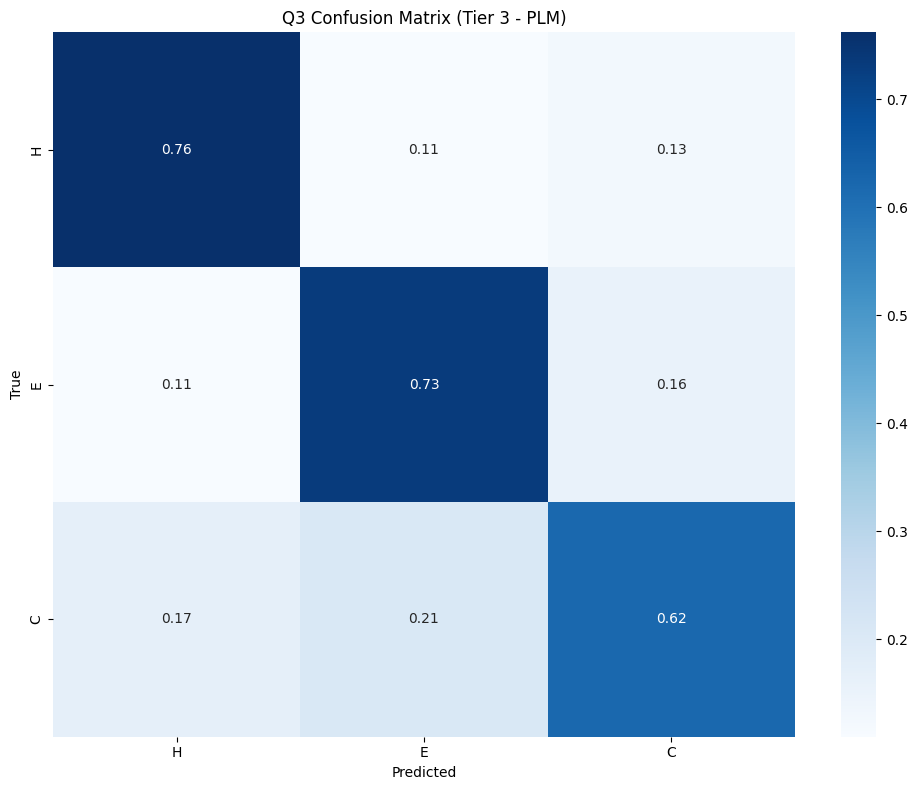

In [13]:
from src.config import SST8_CLASSES, SST3_CLASSES

plot_confusion_matrix(
    report.q8_confusion_matrix,
    SST8_CLASSES,
    title='Q8 Confusion Matrix (Tier 3 - PLM)',
    save_path=f'{config.checkpoint_dir}/q8_confusion_matrix.png',
)

plot_confusion_matrix(
    report.q3_confusion_matrix,
    SST3_CLASSES,
    title='Q3 Confusion Matrix (Tier 3 - PLM)',
    save_path=f'{config.checkpoint_dir}/q3_confusion_matrix.png',
)

## 8. Summary

In [14]:
print("=" * 60)
print("TIER 3 (PLM + BiLSTM) TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Results:")
print(f"  Q8 Accuracy: {report.q8_accuracy:.4f} ({report.q8_accuracy*100:.2f}%)")
print(f"  Q3 Accuracy: {report.q3_accuracy:.4f} ({report.q3_accuracy*100:.2f}%)")
print(f"  Q8 Macro F1: {report.q8_macro_f1:.4f}")
print(f"  Q3 Macro F1: {report.q3_macro_f1:.4f}")

print(f"\nThe power of PLM embeddings:")
print(f"  - Pre-trained on 250M+ protein sequences")
print(f"  - Captures evolutionary and structural information")
print(f"  - No need for MSA (faster inference)")

TIER 3 (PLM + BiLSTM) TRAINING COMPLETE

Best Results:
  Q8 Accuracy: 0.5025 (50.25%)
  Q3 Accuracy: 0.6961 (69.61%)
  Q8 Macro F1: 0.3273
  Q3 Macro F1: 0.6901

The power of PLM embeddings:
  - Pre-trained on 250M+ protein sequences
  - Captures evolutionary and structural information
  - No need for MSA (faster inference)
